In [0]:
# Install TensorFlow 
try:
  # %tensorflow_version command only exists in colab
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
#import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [7]:
#check tensorflow version
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.1.0


#Problem Statement
Using historical data can I predict rainfall based on certain weather conditions


#Get Data
**NOTE:** The dialog box for file selection will only be open for 30 seconds so it doesn't prevent other modules from executing.

In [8]:
# You need to upload the file, AmesHousing-05-2001.csv provided with this course
from google.colab import files

# only load the single file
uploaded = files.upload()
# csv_housefile contains the name of the first, and only file uploaded
csv_hwd = next(iter(uploaded.keys()))

print('User uploaded file "{name}" with length {length} bytes'.format(
      name=csv_hwd, length=len(uploaded[csv_hwd])))


Saving avg-ambient-weather-nozero-20190209-20191230.csv to avg-ambient-weather-nozero-20190209-20191230.csv
User uploaded file "avg-ambient-weather-nozero-20190209-20191230.csv" with length 21910 bytes


In [0]:
import pandas as pd

In [0]:
# create dataframe from historical weather data
df_hwd = pd.read_csv(csv_hwd)

In [11]:
# Visualize the dataset
 
# turn on option to display all columns, otherwise some columns may be hidden
pd.set_option('display.max_columns', None)  
# print the column names and first 5 rows of data
df_hwd.head(5)

,Tier,Date,Outdoor Temperature,Feels Like,Dew Point,Wind Speed,Wind Gust,Max Daily Gust,Wind Direction,Hourly Rain,Daily Rain,Weekly Rain,Monthly Rain,Event Rain,Total Rain,Relative Pressure,Outdoor Humidity,Ultra-Violet Radiation Index,Solar Radiation,Indoor Temperature,Indoor Humidity
0,Average,43829,63.997054,63.800935,50.635972,1.248601,1.883800,9.704713,SSW,0.000515,0.008601,0.266870,4.657452,0.197364,60.748601,29.786605,65.5,0.3,46.455596,74.667084,44.9
1,Average,43828,61.998175,61.998175,61.507489,0.386058,0.639562,3.637737,SSW,0.011307,0.184664,0.184664,4.576993,0.184679,60.654679,30.052927,98.3,0.1,29.904124,74.685403,47.9
2,Average,43822,44.492827,44.486087,44.193594,0.602273,1.042472,6.497017,SSE,0.029915,0.496939,0.755433,4.221172,0.768821,60.268821,30.116001,98.9,0.0,13.358501,75.517685,30.6
3,Average,43821,39.323725,39.323725,35.430262,0.022380,0.064660,1.160765,SSE,0.010574,0.024263,0.024263,3.493003,0.024263,59.524263,30.385099,87.2,0.1,23.544844,75.680595,27.2
4,Average,43816,58.151414,58.146577,55.830446,0.721994,1.149717,6.582603,SSW,0.021888,0.344272,0.344272,3.305339,0.344272,59.314272,29.863004,92.3,0.0,13.762553,75.153597,40.6


In [12]:
 # check to see if there are any nulls in the columns I intend to use for the model
 df_hwd[['Dew Point', 'Outdoor Temperature', 'Relative Pressure', 'Daily Rain']].isnull().values.any()

False

In [0]:
# This function visualizes the data and optionally a learned line
def visualize_data(x_vals, y_vals,
                   addn_x_vals=None, addn_y_vals=None, add_addn_reg_line=False):
  
  f, ax = plt.subplots(figsize=(8,8))
  plt.plot(x_vals, y_vals, 'ro')   # red dot for each data point
  # Optionally plot another set of data points in a different color and symbol
  if (addn_x_vals is not None):
    plt.plot(addn_x_vals, addn_y_vals, 'g^') # green triangles for additional data points
    # Optionally, plot a regression line.
    if (add_addn_reg_line):
      x_min_index = addn_x_vals.argmin()
      x_max_index = addn_x_vals.argmax()
      print(x_min_index,[addn_x_vals[x_min_index],addn_y_vals[x_min_index]] ) 
      print(x_max_index,[addn_x_vals[x_max_index],addn_y_vals[x_max_index]] ) 
      plt.plot([addn_x_vals[x_min_index],addn_y_vals[x_min_index]], 
               [addn_x_vals[x_max_index],addn_y_vals[x_max_index]], 
               'b-')  # draw a blue regression line
    
  plt.tick_params(axis='both', which='major', labelsize=14)
  
  plt.show()  # now plot the line showing the data and the optional line

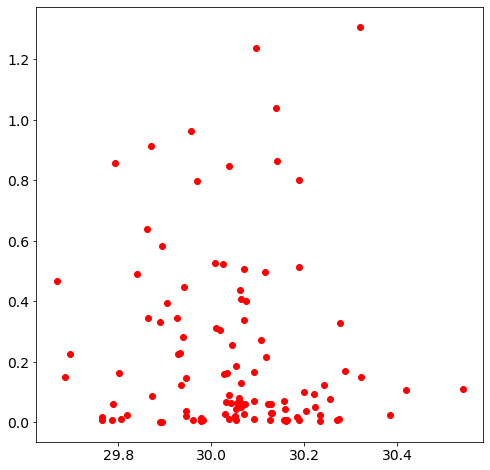

In [14]:
# Plot Relative Pressure vs Daily Rain

visualize_data(df_hwd['Relative Pressure'], df_hwd['Daily Rain'])



In [0]:
# Scale data so Relative Pressure and Rain are on similar scales with values 
#  from 0.0 to 1.0

from sklearn.preprocessing import MinMaxScaler

rp_scaler = MinMaxScaler()
rp_scaled = rp_scaler.fit_transform(df_hwd['Relative Pressure'].values.reshape(-1,1).astype(np.float64))
    
rain_scaler = MinMaxScaler()
rain_scaled = rain_scaler.fit_transform(df_hwd['Daily Rain'].values.reshape(-1,1).astype(np.float64))

In [0]:
# Create model using the TensorFlow Keras library
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation='linear', input_shape=(1,),
                                kernel_initializer='random_uniform',
                                bias_initializer='zeros'))


In [0]:
# Compile model
optimizer = "sgd"
model.compile(loss='mean_squared_error', optimizer=optimizer )


In [0]:
# Split the dataset into training dataset - 70%, Testing dataset - 30%
from sklearn.model_selection import train_test_split

rp_train_scaled, rp_test_scaled, rain_train_scaled, rain_test_scaled = train_test_split(rp_scaled, 
                                                    rain_scaled, 
                                                    test_size=0.3, random_state=42)

In [19]:

# Train model using data
initial_epochs = 8
batch_size = 10
train_hist = model.fit(rp_train_scaled, rain_train_scaled, 
                       epochs=initial_epochs, batch_size=batch_size, verbose=1)


Train on 74 samples
Epoch 1/8
74/74 [==============================] - 2s 26ms/sample - loss: 0.0780
Epoch 2/8
74/74 [==============================] - 0s 351us/sample - loss: 0.0696
Epoch 3/8
74/74 [==============================] - 0s 307us/sample - loss: 0.0631
Epoch 4/8
74/74 [==============================] - 0s 264us/sample - loss: 0.0593
Epoch 5/8
74/74 [==============================] - 0s 275us/sample - loss: 0.0566
Epoch 6/8
74/74 [==============================] - 0s 285us/sample - loss: 0.0543
Epoch 7/8
74/74 [==============================] - 0s 431us/sample - loss: 0.0530
Epoch 8/8
74/74 [==============================] - 0s 283us/sample - loss: 0.0523


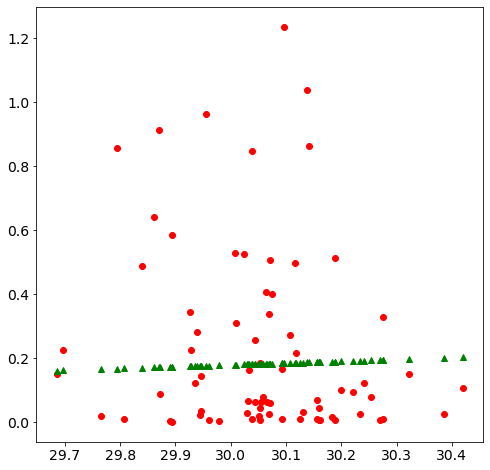

In [20]:

#  predict the price with our trained model
rain_predicted_scaled =  model.predict(rp_train_scaled)
visualize_data(rp_scaler.inverse_transform(rp_train_scaled), rain_scaler.inverse_transform(rain_train_scaled),
               rp_scaler.inverse_transform(rp_train_scaled), rain_scaler.inverse_transform(rain_predicted_scaled),
               add_addn_reg_line=False)
               

<class 'tensorflow.python.keras.callbacks.History'>


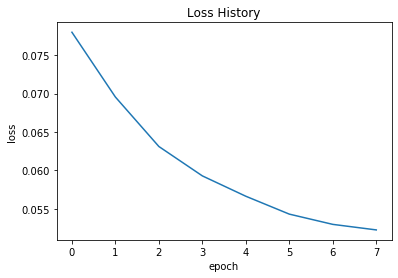

In [21]:
# plot the loss history to see if the model is trained as much as it can be (without being over-trained)
def plot_loss(hist):
  # plot the loss
  plt.title('Loss History')
  plt.plot(hist.history['loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()

print(type(train_hist))
plot_loss(train_hist)

In [0]:
# Loss is not flat, so train for additional epochs
# Also capture the changes over time in the history variable, train_hist_addn so we 
#   can see if loss is converging
addn_epochs = 1200
train_hist_addn =model.fit(rp_train_scaled, rain_train_scaled,  
                     epochs=addn_epochs, verbose=0)

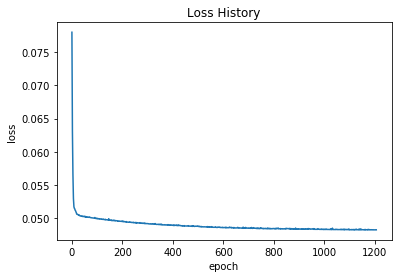

In [23]:
# add the addition epochs to the  training history
train_hist.history['loss'].extend(train_hist_addn.history['loss'])   
plot_loss(train_hist)

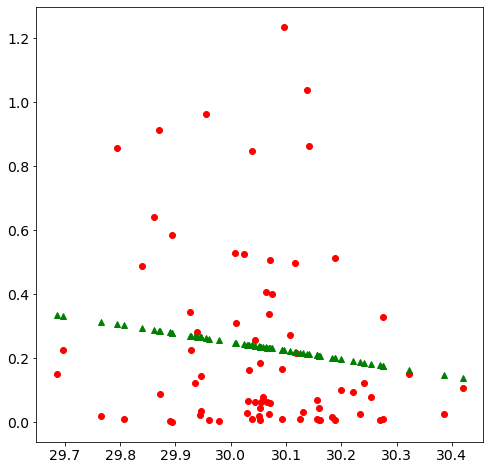

In [24]:
# Visualize data and regression line for learned weights
rain_predicted_scaled =  model.predict(rp_train_scaled)
visualize_data(rp_scaler.inverse_transform(rp_train_scaled), 
               rain_scaler.inverse_transform(rain_train_scaled),
               rp_scaler.inverse_transform(rp_train_scaled), 
               rain_scaler.inverse_transform(rain_predicted_scaled),
               add_addn_reg_line=False)


prediction mean squared error: 0.051893481524005136

Green triangles are Test relative pressure with predicted rain


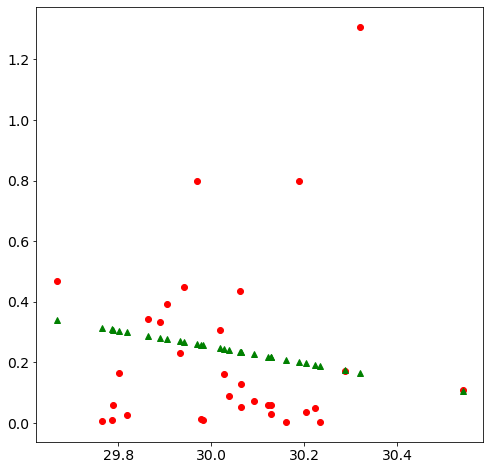

In [25]:
# Make a rain prediction using Test data

rain_test_pred_scaled = model.predict(rp_test_scaled)

# calculate the mean squared error for the prediction, lower is better
from sklearn.metrics import mean_squared_error
print("prediction mean squared error:", 
          mean_squared_error(rain_test_scaled, rain_test_pred_scaled ))

# Visualize data
#    plus the test relative pressure and rain
print('\nGreen triangles are Test relative pressure with predicted rain')
visualize_data(rp_scaler.inverse_transform(rp_test_scaled),
               rain_scaler.inverse_transform(rain_test_scaled),
               rp_scaler.inverse_transform(rp_test_scaled), 
               rain_scaler.inverse_transform(rain_test_pred_scaled),
               add_addn_reg_line=False)